#Modeling how method affects serial dilution experiments.

A recent paper by Ekins et al. [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a large discrepany was observed in IC50 assay values in which either a LabCyte Echo acoustic dispensing unit or a Tecan Genesis liquid handling workstation were used in performing the assays.  

This discrepancy may be due to any number of factors, but one of the main features of the Echo is its direct dispensing technology that allows a dilution series over several orders of magnitude in concetration to be created directly without the need for serial dilution.

#<span style="color:blue">insert figure here</span>

Here we experiment with some simple python models to test if the observed discrepancy can be explained by the difference in the accuracy with which a serial dilution can be created by these two technologies?

### 0. Define assay setup

In [2]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
%pylab inline
sns.set(style='white')
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


Our general assay setup is of 8 points of 100 uL each in our dilution series (including the original concentration), starting with an initial concentration of 10 mM in DMSO stock. Each point will be diluted be a factor 2 dilution of the previous step.

#<span style="color:blue">insert figure here</span>

In [3]:
# define assay setup
ndilutions = 8 # number of points in dilution series (including original concentration)
V0 = 100e-6 # 100 uL - original volume
C0 = 10e-3 # 10 mM initial - original concentration

# dilution series specific parameters
Vtransfer = 50e-6 # 50 uL transfer volume
Vbuffer = 50e-6 # 50 uL buffer in each before transfer

In [4]:
# define dilution_series function
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

In [5]:
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

In [6]:
print "Thus we now have an %s part dilution series from %s M to %s M." % (ndilutions, C0, ideal_concentrations[-1])

Thus we now have an 8 part dilution series from 0.01 M to 7.8125e-05 M.


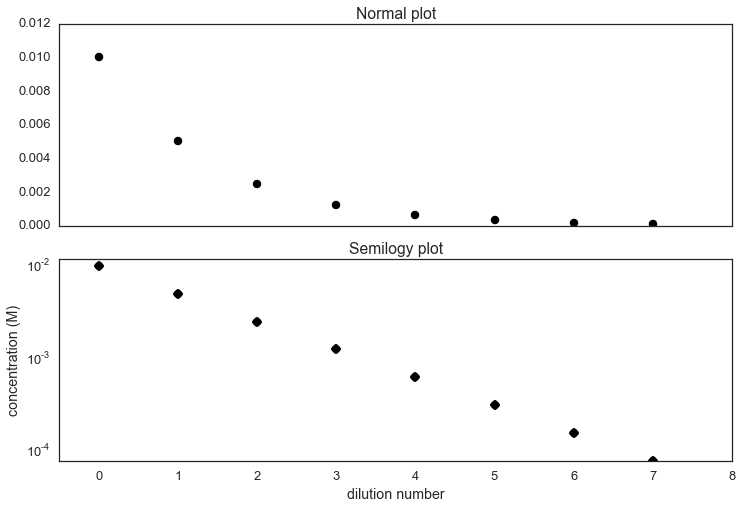

In [7]:
# Plot!
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(range(ndilutions), ideal_concentrations, lw=4)
ax1.set_title("Normal plot")
ax2.semilogy(range(ndilutions), ideal_concentrations,'ko')
ax2.set_title("Semilogy plot")
plt.xlabel('dilution number')
plt.ylabel('concentration (M)')
ax1.axis([-0.5, ndilutions, 0.0, C0*1.2])
ax2.axis([-0.5, ndilutions, 0.0, C0*1.2])
f.tight_layout()

First we'll model how a human or a liquid-handling robot does a serial dilution, then we'll model how direct dispense technology does for the same dilution series.

### 1. Dilution and dispensing by a liquid-handling robot.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). We'll ignore other contributions to error, such as compound stickiness, insolubility, etc.



Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

I couldn't find published specs for standard bias and error for the Genesis (which appears to be no longer produced), so we'll use data for a Beckman NX/FX span-8 instead:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)


In [8]:
# define relevant pipetting error function
def tecan_genesis_pipetting_model(volume):
    # Assume published imprecision/inaccuracy for Beckman Biomek NX/FX span-8.
    from scipy.interpolate import interp1d
    imprecision_function = interp1d([0.5e-6, 1e-6, 5e-6, 10e-6, 50e-6, 100e-6, 250e-6, 950e-6], [0.10, 0.07, 0.05, 0.05, 0.05, 0.05, 0.02, 0.01]) # published imprecision for Beckman NX/FX span-8
    inaccuracy_function = interp1d([0.5e-6, 1e-6, 100e-6, 250e-6, 900e-6], [0.05, 0.03, 0.03, 0.02, 0.01]) # published inaccuracy for Beckman NX/FX span-8
    return [inaccuracy_function(volume), imprecision_function(volume)]    

#<span style="color:blue">can we not just add (a) and (b) to our previous dilution_series function?? Also are these not just both (a) inaccuracies?? Also what about V0?</span>

In [14]:
# define ROBOT_dilution_series function
def ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [15]:
[actual_volumes, actual_concentrations] = ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

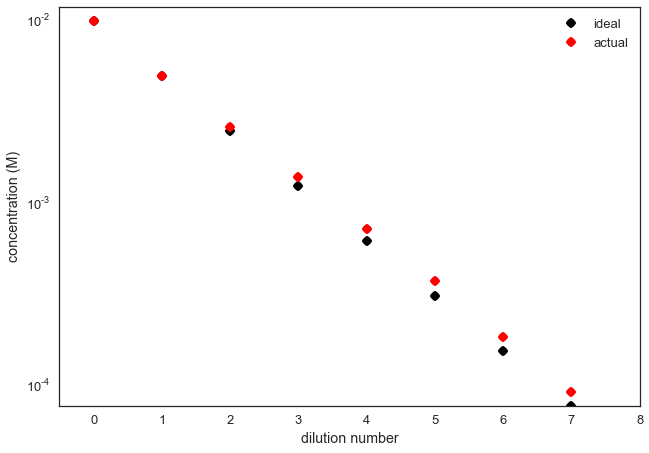

In [17]:
#Plot!
plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions, 0.0, C0*1.2]);

What if we plot the relative errors in concentration, volume, and total quantity of compound per well generated in this particular replicate of the dilution series?

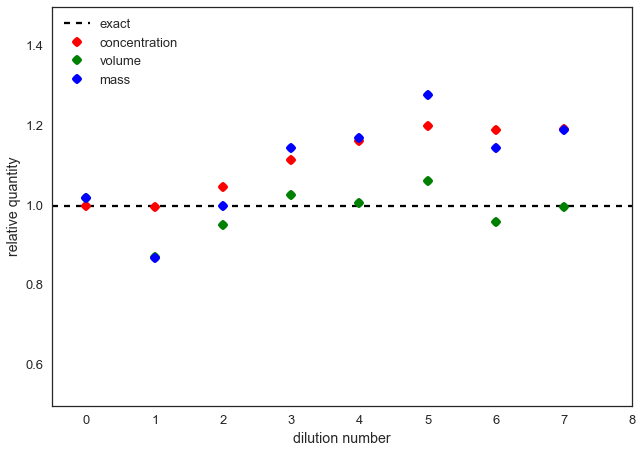

In [30]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--')
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', range(ndilutions), actual_volumes / ideal_volumes, 'go', range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo')
plt.legend(['exact', 'concentration', 'volume', 'mass'], loc='upper left')
plt.axis([-0.5, ndilutions, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number')

If we repeat the experiment many times, we can estimate the CV for each dilution number.

In [26]:
# Repeat the experiment many (5000) times.
nreplicates = 5000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

In [27]:
# Compute CVs    
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

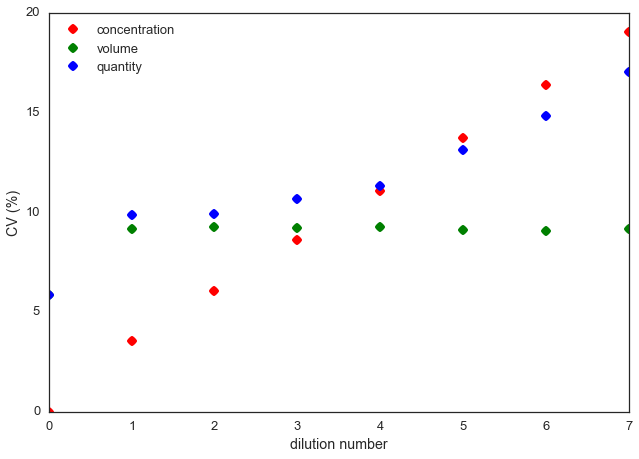

In [31]:
# Plot!
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', range(ndilutions), volumes_cv*100, 'go', range(ndilutions), quantity_cv*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('CV (%)');
plt.legend(['concentration', 'volume', 'quantity'], loc='upper left');

The biases may also be important, so let's plot those too.

In [32]:
#more later

### 2. Dispensing by direct dispensing.